In [1]:
# follow the instruction: https://github.com/jianhuupenn/SpaGCN/blob/master/tutorial/tutorial.ipynb

import anndata as ad
import SpaGCN as spg
import pandas as pd
import numpy as np
import scanpy as sc
import random
import torch
import os

/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from SpaGCN import simple_GC_DEC
class SpaGCN_embed(spg.SpaGCN):
    def __init__(self):
        super(SpaGCN_embed, self).__init__()
        self.l=None

    
    def train(self,adata,adj,embed,
        num_pcs=50, 
        lr=0.005,
        max_epochs=2000,
        weight_decay=0,
        opt="admin",
        init_spa=True,
        init="louvain", #louvain or kmeans
        n_neighbors=10, #for louvain
        n_clusters=None, #for kmeans
        res=0.4, #for louvain
        tol=1e-3):
        self.num_pcs=num_pcs
        self.res=res
        self.lr=lr
        self.max_epochs=max_epochs
        self.weight_decay=weight_decay
        self.opt=opt
        self.init_spa=init_spa
        self.init=init
        self.n_neighbors=n_neighbors
        self.n_clusters=n_clusters
        self.res=res
        self.tol=tol
        assert adata.shape[0]==adj.shape[0]==adj.shape[1]

        # embed = embed[:,0:num_pcs]

        ###------------------------------------------###
        if self.l is None:
            raise ValueError('l should not be set before fitting the model!')
        adj_exp=np.exp(-1*(adj**2)/(2*(self.l**2)))
        #----------Train model----------
        adj_exp = np.ascontiguousarray(adj_exp)
        embed = np.ascontiguousarray(embed)
        
        self.model=simple_GC_DEC(embed.shape[1],embed.shape[1])
        self.model.fit(embed,adj_exp,lr=self.lr,max_epochs=self.max_epochs,weight_decay=self.weight_decay,opt=self.opt,init_spa=self.init_spa,init=self.init,n_neighbors=self.n_neighbors,n_clusters=self.n_clusters,res=self.res, tol=self.tol)
        self.embed=embed
        self.adj_exp=adj_exp

In [7]:
def search_res(adata, adj, l, target_num,use_rep, start=0.4, step=0.1, tol=5e-3, lr=0.05, max_epochs=10, r_seed=100, t_seed=100, n_seed=100, max_run=10):
    
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    res=start
    print("Start at res = ", res, "step = ", step)
    clf=SpaGCN_embed()
    clf.set_l(l)
    clf.train(adata,adj,adata.obsm[use_rep],init_spa=True,res=res, tol=tol, lr=lr, max_epochs=max_epochs,n_clusters=target_num)
    y_pred, _=clf.predict()
    old_num=len(set(y_pred))
    print("Res = ", res, "Num of clusters = ", old_num)
    run=0
    while old_num!=target_num:
        random.seed(r_seed)
        torch.manual_seed(t_seed)
        np.random.seed(n_seed)
        old_sign=1 if (old_num<target_num) else -1
        clf=SpaGCN_embed()
        clf.set_l(l)
        clf.train(adata,adj,adata.obsm[use_rep],init_spa=True,res=res+step*old_sign, tol=tol, lr=lr, max_epochs=max_epochs,n_clusters=target_num)
        y_pred, _=clf.predict()
        new_num=len(set(y_pred))
        print("Res = ", res+step*old_sign, "Num of clusters = ", new_num)
        if new_num==target_num:
            res=res+step*old_sign
            print("recommended res = ", str(res))
            return res
        new_sign=1 if (new_num<target_num) else -1
        if new_sign==old_sign:
            res=res+step*old_sign
            print("Res changed to", res)
            old_num=new_num
        else:
            step=step/2
            print("Step changed to", step)
        if run >max_run:
            print("Exact resolution not found")
            print("Recommended res = ", str(res))
            return res
        run+=1
    print("recommended res = ", str(res))
    return res

def run_SpaGCN_embed(adata,use_rep='spanve.imputed.pca.pre', p = 0.5):

    r_seed = t_seed = n_seed = 0
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    
    # calculate adjacency matrix
    print('# calculate adjacency matrix')
    x_array = adata.obsm["spatial"][:,0].tolist()
    y_array = adata.obsm["spatial"][:,1].tolist()
    adj = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)

    # set hyper-parameters
    print('# set hyper-parameters')
    l = spg.search_l(p, adj, start = 0.01, end = 1000, tol = 0.01, max_run = 100)
    n_clusters = adata.obs['ground_truth'].unique().size
    res = search_res(
        adata, adj, l, n_clusters, use_rep=use_rep,
        start = 0.7, step = 0.1, 
        tol = 5e-3, lr = 0.05, 
        max_epochs = 20, r_seed = r_seed, t_seed = t_seed, n_seed = n_seed)

    # run spaGCN
    print('# run spaGCN')
    clf = SpaGCN_embed()
    clf.set_l(l)

    clf.train(adata, adj, adata.obsm[use_rep] ,init_spa = True, res = res, tol = 5e-3, lr = 0.05, max_epochs = 200,n_clusters=n_clusters)
    y_pred, prob = clf.predict()
    adata.obs["pred"]= y_pred
    adata.obs["pred"] = adata.obs["pred"].astype('category')

    # cluster refinement
    print('# cluster refinement')
    adj_2d = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)
    refined_pred = spg.refine(sample_id = adata.obs.index.tolist(), pred = adata.obs["pred"].tolist(), dis = adj_2d, shape = "hexagon")

    return refined_pred

def run_SpaGCN_base(adata, p = 0.5):
    r_seed = t_seed = n_seed = 0
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    
    # calculate adjacency matrix
    print('# calculate adjacency matrix')
    x_array = adata.obsm["spatial"][:,0].tolist()
    y_array = adata.obsm["spatial"][:,1].tolist()
    adj = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)

    sc.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    # sc.pp.pca(adata)
    
    # set hyper-parameters
    print('# set hyper-parameters')
    l = spg.search_l(p, adj, start = 0.01, end = 1000, tol = 0.01, max_run = 100)
    n_clusters = adata.obs['ground_truth'].unique().size
    res = spg.search_res(
        adata, adj, l, n_clusters, #use_rep='X_pca',
        start = 0.7, step = 0.1, 
        tol = 5e-3, lr = 0.05, 
        max_epochs = 20, r_seed = r_seed, t_seed = t_seed, n_seed = n_seed)

    # run spaGCN
    print('# run spaGCN')
    clf = spg.SpaGCN()
    clf.set_l(l)

    clf.train(adata, adj ,init_spa = True, res = res, tol = 5e-3, lr = 0.05, max_epochs = 200,n_clusters=n_clusters,)
    y_pred, prob = clf.predict()
    adata.obs["pred"]= y_pred
    adata.obs["pred"] = adata.obs["pred"].astype('category')

    # cluster refinement
    print('# cluster refinement')
    adj_2d = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)
    refined_pred = spg.refine(sample_id = adata.obs.index.tolist(), pred = adata.obs["pred"].tolist(), dis = adj_2d, shape = "hexagon")

    return refined_pred

In [8]:
data_dir = './recode/IMPUTEDLIBD/processed/'
data_ids = [i for i in os.listdir(data_dir) if i.endswith('.h5ad')]
recoder = pd.DataFrame(columns = ['data','ari','ami','pre_type','clust_method'])

from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from tqdm import tqdm

for data_id in tqdm(data_ids):

    adata = sc.read_h5ad(os.path.join(data_dir,data_id))
    ground = adata.obs['ground_truth']
    
    labels_embed = run_SpaGCN_embed(adata)
    labels_base = run_SpaGCN_base(adata)
    pd.DataFrame(
        {
            'spanve_impute':labels_embed,
            'base':labels_base
        }
    ).to_csv(f"./recode/IMPUTEDLIBD/SG/{data_id.replace('.h5ad','.csv')}")
    recoder.loc[len(recoder),:] = data_id,ari(ground,labels_embed),ami(ground,labels_embed),'spanve_impute','SpaGCN'
    recoder.loc[len(recoder),:] = data_id,ari(ground,labels_base),ami(ground,labels_base),'raw','SpaGCN'

  0%|                                                                                                                                                                          | 0/12 [00:00<?, ?it/s]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 312.00739089512916]
Run 2: l [0.01, 500.005], p [0.0, 85.49689483642578]
Run 3: l [0.01, 250.0075], p [0.0, 21.679431915283203]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.808452129364014]
Run 5: l [0.01, 62.509375], p [0.0, 0.5168116092681885]
Run 6: l [31.2596875, 62.509375], p [0.0003445148468017578, 0.5168116092681885]
Run 7: l [46.884531249999995, 62.509375], p [0.07710742950439453, 0.5168116092681885]
Run 8: l [54.69695312499999, 62.509375], p [0.24361300468444824, 0.5168116092681885]
Run 9: l [58.6031640625, 62.509375], p [0.3679589033126831, 0.5168116092681885]
Run 10: l [60.556269531249995, 62.509375], p [0.43952035903930664, 0.5168116092681885]
Run 11: l [61.532822265625, 62.509375], p [0.47747576236724854, 0.5168116092681885]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0

  8%|█████████████▌                                                                                                                                                    | 1/12 [01:21<14:55, 81.39s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 302.06612445704735]
Run 2: l [0.01, 500.005], p [0.0, 83.56209564208984]
Run 3: l [0.01, 250.0075], p [0.0, 21.290042877197266]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.743496894836426]
Run 5: l [0.01, 62.509375], p [0.0, 0.5107473134994507]
Run 6: l [31.2596875, 62.509375], p [0.0003401041030883789, 0.5107473134994507]
Run 7: l [46.884531249999995, 62.509375], p [0.07618176937103271, 0.5107473134994507]
Run 8: l [54.69695312499999, 62.509375], p [0.24073255062103271, 0.5107473134994507]
Run 9: l [58.6031640625, 62.509375], p [0.3636287450790405, 0.5107473134994507]
Run 10: l [60.556269531249995, 62.509375], p [0.43435657024383545, 0.5107473134994507]
Run 11: l [61.532822265625, 62.509375], p [0.4718698263168335, 0.5107473134994507]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.

 17%|███████████████████████████                                                                                                                                       | 2/12 [02:20<11:21, 68.19s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 313.0379008820827]
Run 2: l [0.01, 500.005], p [0.0, 85.58491516113281]
Run 3: l [0.01, 250.0075], p [0.0, 21.68450164794922]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.809234619140625]
Run 5: l [0.01, 62.509375], p [0.0, 0.5169980525970459]
Run 6: l [31.2596875, 62.509375], p [0.00034499168395996094, 0.5169980525970459]
Run 7: l [46.884531249999995, 62.509375], p [0.07715213298797607, 0.5169980525970459]
Run 8: l [54.69695312499999, 62.509375], p [0.2437218427658081, 0.5169980525970459]
Run 9: l [58.6031640625, 62.509375], p [0.36810553073883057, 0.5169980525970459]
Run 10: l [60.556269531249995, 62.509375], p [0.43968665599823, 0.5169980525970459]
Run 11: l [61.532822265625, 62.509375], p [0.4776519536972046, 0.5169980525970459]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Ep

 25%|████████████████████████████████████████▌                                                                                                                         | 3/12 [03:45<11:23, 75.96s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 311.427603618283]
Run 2: l [0.01, 500.005], p [0.0, 84.65625]
Run 3: l [0.01, 250.0075], p [0.0, 21.38892364501953]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.7252197265625]
recommended l =  62.509375
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  17
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  14
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  13
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Res =  0.4 Num of clusters =  11
Res changed to 0.4
Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Res =  0.30000000000000004 Num of 

 33%|██████████████████████████████████████████████████████                                                                                                            | 4/12 [05:30<11:40, 87.53s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 311.96597550300635]
Run 2: l [0.01, 500.005], p [0.0, 84.9486083984375]
Run 3: l [0.01, 250.0075], p [0.0, 21.482959747314453]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.754456043243408]
recommended l =  62.509375
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  14
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  13
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  12
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Res =  0.4 Num of clusters =  9
Res changed to 0.4
Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Res =  0.3000000000000

 42%|███████████████████████████████████████████████████████████████████▌                                                                                              | 5/12 [07:11<10:45, 92.21s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 303.8774432377918]
Run 2: l [0.01, 500.005], p [0.0, 83.65432739257812]
Run 3: l [0.01, 250.0075], p [0.0, 21.296619415283203]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.740560531616211]
Run 5: l [0.01, 62.509375], p [0.0, 0.5103416442871094]
Run 6: l [31.2596875, 62.509375], p [0.0003401041030883789, 0.5103416442871094]
Run 7: l [46.884531249999995, 62.509375], p [0.07613587379455566, 0.5103416442871094]
Run 8: l [54.69695312499999, 62.509375], p [0.24055945873260498, 0.5103416442871094]
Run 9: l [58.6031640625, 62.509375], p [0.3633519411087036, 0.5103416442871094]
Run 10: l [60.556269531249995, 62.509375], p [0.4340183734893799, 0.5103416442871094]
Run 11: l [61.532822265625, 62.509375], p [0.4714987277984619, 0.5103416442871094]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                 | 6/12 [08:54<09:36, 96.07s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 304.4529761723347]
Run 2: l [0.01, 500.005], p [0.0, 84.13076782226562]
Run 3: l [0.01, 250.0075], p [0.0, 21.441434860229492]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.772664546966553]
Run 5: l [0.01, 62.509375], p [0.0, 0.5138150453567505]
Run 6: l [31.2596875, 62.509375], p [0.0003432035446166992, 0.5138150453567505]
Run 7: l [46.884531249999995, 62.509375], p [0.07670390605926514, 0.5138150453567505]
Run 8: l [54.69695312499999, 62.509375], p [0.24225592613220215, 0.5138150453567505]
Run 9: l [58.6031640625, 62.509375], p [0.3658638000488281, 0.5138150453567505]
Run 10: l [60.556269531249995, 62.509375], p [0.4369940757751465, 0.5138150453567505]
Run 11: l [61.532822265625, 62.509375], p [0.4747190475463867, 0.5138150453567505]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 7/12 [10:17<07:38, 91.79s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 310.4714764706403]
Run 2: l [0.01, 500.005], p [0.0, 85.17036437988281]
Run 3: l [0.01, 250.0075], p [0.0, 21.613140106201172]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.797861576080322]
Run 5: l [0.01, 62.509375], p [0.0, 0.5156970024108887]
Run 6: l [31.2596875, 62.509375], p [0.0003432035446166992, 0.5156970024108887]
Run 7: l [46.884531249999995, 62.509375], p [0.07690870761871338, 0.5156970024108887]
Run 8: l [54.69695312499999, 62.509375], p [0.2430485486984253, 0.5156970024108887]
Run 9: l [58.6031640625, 62.509375], p [0.36713922023773193, 0.5156970024108887]
Run 10: l [60.556269531249995, 62.509375], p [0.43855786323547363, 0.5156970024108887]
Run 11: l [61.532822265625, 62.509375], p [0.4764382839202881, 0.5156970024108887]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 8/12 [11:16<05:24, 81.23s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 309.02506516689647]
Run 2: l [0.01, 500.005], p [0.0, 84.78437042236328]
Run 3: l [0.01, 250.0075], p [0.0, 21.497591018676758]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.774121284484863]
Run 5: l [0.01, 62.509375], p [0.0, 0.5137132406234741]
Run 6: l [31.2596875, 62.509375], p [0.00034296512603759766, 0.5137132406234741]
Run 7: l [46.884531249999995, 62.509375], p [0.07667315006256104, 0.5137132406234741]
Run 8: l [54.69695312499999, 62.509375], p [0.24218857288360596, 0.5137132406234741]
Run 9: l [58.6031640625, 62.509375], p [0.36577796936035156, 0.5137132406234741]
Run 10: l [60.556269531249995, 62.509375], p [0.4368997812271118, 0.5137132406234741]
Run 11: l [61.532822265625, 62.509375], p [0.474621057510376, 0.5137132406234741]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 9/12 [12:17<03:44, 75.00s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 304.1220175019325]
Run 2: l [0.01, 500.005], p [0.0, 83.85807037353516]
Run 3: l [0.01, 250.0075], p [0.0, 21.341144561767578]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.750619411468506]
Run 5: l [0.01, 62.509375], p [0.0, 0.5111031532287598]
Run 6: l [31.2596875, 62.509375], p [0.0003393888473510742, 0.5111031532287598]
Run 7: l [46.884531249999995, 62.509375], p [0.07618057727813721, 0.5111031532287598]
Run 8: l [54.69695312499999, 62.509375], p [0.24083411693572998, 0.5111031532287598]
Run 9: l [58.6031640625, 62.509375], p [0.36383748054504395, 0.5111031532287598]
Run 10: l [60.556269531249995, 62.509375], p [0.4346342086791992, 0.5111031532287598]
Run 11: l [61.532822265625, 62.509375], p [0.47218525409698486, 0.5111031532287598]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 10/12 [13:12<02:17, 68.64s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 303.86047687500917]
Run 2: l [0.01, 500.005], p [0.0, 83.68516540527344]
Run 3: l [0.01, 250.0075], p [0.0, 21.29427146911621]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.7398552894592285]
Run 5: l [0.01, 62.509375], p [0.0, 0.5102378129959106]
Run 6: l [31.2596875, 62.509375], p [0.0003401041030883789, 0.5102378129959106]
Run 7: l [46.884531249999995, 62.509375], p [0.07612454891204834, 0.5102378129959106]
Run 8: l [54.69695312499999, 62.509375], p [0.2405151128768921, 0.5102378129959106]
Run 9: l [58.6031640625, 62.509375], p [0.36328089237213135, 0.5102378129959106]
Run 10: l [60.556269531249995, 62.509375], p [0.433931827545166, 0.5102378129959106]
Run 11: l [61.532822265625, 62.509375], p [0.47140347957611084, 0.5102378129959106]
recommended l =  62.021098632812496
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 11/12 [14:04<01:03, 63.56s/it]

# calculate adjacency matrix
Calculateing adj matrix using xy only...
# set hyper-parameters
Run 1: l [0.01, 1000], p [0.0, 297.97099796262245]
Run 2: l [0.01, 500.005], p [0.0, 82.79729461669922]
Run 3: l [0.01, 250.0075], p [0.0, 21.207942962646484]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.7304368019104]
recommended l =  62.509375
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  19
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  17
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  15
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Res =  0.4 Num of clusters =  14
Res changed to 0.4
Initializing cluster centers with louvain, resolution =  0.30000000000000004
Epoch  0
Epoch  10
Res =  0.3000000000000

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [14:56<00:00, 74.70s/it]


In [8]:
recoder.to_csv('./recode/IMPUTEDLIBD/SG.LV.res.csv')

In [9]:
recoder

,data,ari,ami,pre_type,clust_method
0,151507.h5ad,0.52432,0.613175,spanve_impute,SpaGCN
1,151507.h5ad,0.433302,0.57755,raw,SpaGCN
2,151676.h5ad,0.367553,0.47187,spanve_impute,SpaGCN
3,151676.h5ad,0.361445,0.497173,raw,SpaGCN
4,151508.h5ad,0.466086,0.568889,spanve_impute,SpaGCN
5,151508.h5ad,0.447368,0.564533,raw,SpaGCN
6,151509.h5ad,0.495378,0.62973,spanve_impute,SpaGCN
7,151509.h5ad,0.332844,0.555372,raw,SpaGCN
8,151510.h5ad,0.364871,0.578279,spanve_impute,SpaGCN
9,151510.h5ad,0.451504,0.578734,raw,SpaGCN


<AxesSubplot:xlabel='pre_type', ylabel='ari'>

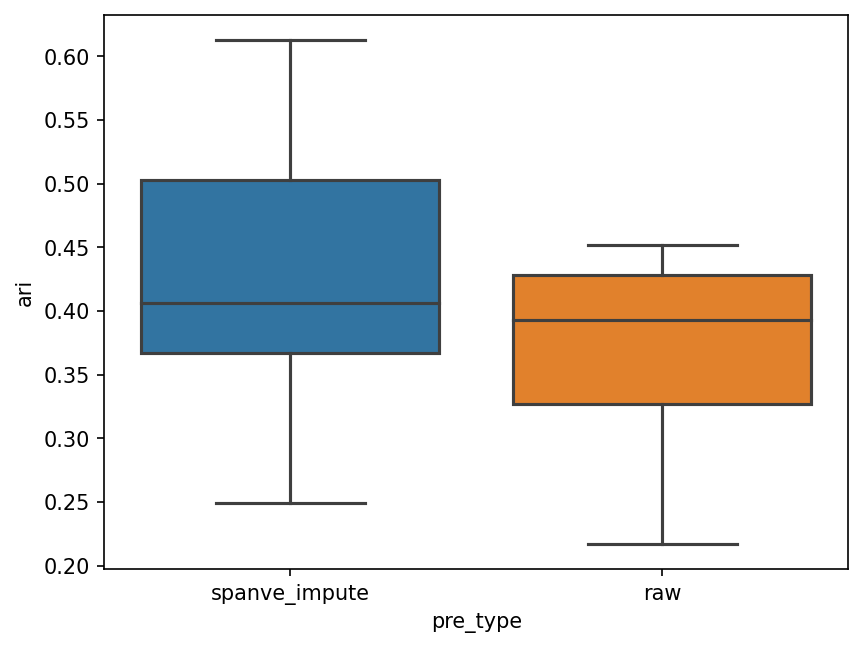

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# recoder = pd.read_csv('./recode/IMPUTEDLIBD/LD.res.csv',index_col=0)

f = plt.figure(dpi=150)
sns.boxplot(
    data=recoder,
    y='ari',x = 'pre_type'
)